<a href="https://colab.research.google.com/github/blindTissue/NLP-Project/blob/main/attention_trainable_alibi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import math
import numpy as np


In [ ]:
training_length = 8000
validation_length = 2000

dataset = load_dataset("boolq")

class BoolQADataset(torch.utils.data.Dataset):
    """
    Dataset for the dataset of BoolQ questions and answers
    """

    def __init__(self, passages, questions, answers, tokenizer, max_len):
        self.passages = passages
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.answers)

    def __getitem__(self, index):
        """
        This function is called by the DataLoader to get an instance of the data
        :param index:
        :return:
        """

        passage = str(self.passages[index])
        question = self.questions[index]
        answer = self.answers[index]

        # this is input encoding for your model. Note, question comes first since we are doing question answering
        # and we don't wnt it to be truncated if the passage is too long
        input_encoding = question + " [SEP] " + passage

        # encode_plus will encode the input and return a dictionary of tensors
        encoded_review = self.tokenizer.encode_plus(
            input_encoding,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoded_review['input_ids'][0],  # we only have one example in the batch
            'attention_mask': encoded_review['attention_mask'][0],
            # attention mask tells the model where tokens are padding
            'labels': torch.tensor(answer, dtype=torch.long)  # labels are the answers (yes/no)
        }

dataset['train'][0]

dataset_train_subset = dataset['train'][:training_length]
#dataset_train_subset = dataset['train'][:100]

dataset_dev_subset = dataset['validation'][:validation_length]

max_len = 128

mytokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_dataset = BoolQADataset(
        passages=list(dataset_train_subset['passage']),
        questions=list(dataset_train_subset['question']),
        answers=list(dataset_train_subset['answer']),
        tokenizer=mytokenizer,
        max_len=max_len
)

validation_dataset = BoolQADataset(
        passages=list(dataset_dev_subset['passage']),
        questions=list(dataset_dev_subset['question']),
        answers=list(dataset_dev_subset['answer']),
        tokenizer=mytokenizer,
        max_len=max_len
    )

train_dataloader = DataLoader(train_dataset, 1)
validation_dataloader = DataLoader(validation_dataset, 32)



  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config['vocab_size'], config['hidden_size'], padding_idx=config['pad_token_id'])

        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, input_ids):
        input_shape = input_ids.size()
        seq_length = input_shape[1]
        device = input_ids.device

        embeddings = self.word_embeddings(input_ids)

        embeddings = embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertSelfAttention(nn.Module):
      def __init__(self, config):
        super().__init__()

        assert config["hidden_size"] % config["num_of_attention_heads"] == 0, "The hidden size is not a multiple of the number of attention heads"

        self.num_attention_heads = config['num_of_attention_heads']
        self.attention_head_size = int(config['hidden_size'] / config['num_of_attention_heads'])
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config['hidden_size'], self.all_head_size)
        self.key = nn.Linear(config['hidden_size'], self.all_head_size)
        self.value = nn.Linear(config['hidden_size'], self.all_head_size)
        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.max_position_embeddings = config["max_position_embeddings"]
        #self.distance_embedding = nn.Embedding(2 * self.max_position_embeddings - 1, self.attention_head_size)

        self.trainable_distance = nn.Parameter(self.initial_distance())

        #print("distance_embedding")
        #print(self.attention_head_size)

      def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

      def initial_distance(self):
          new_m = torch.randn(self.num_attention_heads, self.max_position_embeddings, 
                                                           self.max_position_embeddings)
          for i in range(self.num_attention_heads):
              bias = 2 ** (-8 / (i + 1))
              for j in range(self.max_position_embeddings):
                  for k in range(self.max_position_embeddings):
                      new_m[i][j][k] = bias * abs(j-k)
          return new_m
                      
              


      def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)                             
        mixed_key_layer = self.key(hidden_states)                                
        mixed_value_layer = self.value(hidden_states)                            
        
        query_layer = self.transpose_for_scores(mixed_query_layer)               
        key_layer = self.transpose_for_scores(mixed_key_layer)                    
        value_layer = self.transpose_for_scores(mixed_value_layer) 

        query_length, key_length = query_layer.shape[2], key_layer.shape[2]
        #position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
        #position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
        #distance = position_ids_l - position_ids_r
        #positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
        #print(positional_embedding.shape) 
        #print("query layer shape")
        #print(query_layer.shape) 
        #relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)



        
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) 
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        
        #attention_scores = attention_scores + relative_position_scores
        attention_scores = attention_scores + self.trainable_distance
        #print(attention_scores.shape) 
        attention_probs = nn.Softmax(dim=-1)(attention_scores)                    
        context_layer = torch.matmul(attention_probs, value_layer)
        #build_alibi_tensor(config['num_of_attention_heads'], )                

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()            
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) 
        context_layer = context_layer.view(*new_context_layer_shape)             
        
        output =  self.dense(context_layer)
        
        return output




class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        

    def forward(self, input_tensor):
        self_output = self.self(input_tensor)
        attention_output = self.output(self_output, input_tensor)
        return attention_output

class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['intermediate_size'])
        self.intermediate_act_fn = nn.GELU()

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states
    
class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['intermediate_size'], config['hidden_size'])
        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
        
    def forward(self, hidden_states):
        #print(hidden_states)
        attention_output = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config['num_hidden_layers'])])
        
    def forward(self, hidden_states):
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states)
        return hidden_states
    
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        #print(first_token_tensor.shape)
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
    


class BertModel(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded_layers = self.encoder(embedding_output)
        sequence_output = encoded_layers
        pooled_output = self.pooler(sequence_output)
        return encoded_layers, pooled_output
    
class BertForBinaryClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])
        self.classifier = nn.Linear(config['hidden_size'], 1)
    def forward(self, input_ids):
        _, pooled_output = self.bert(input_ids)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits
    



hidden_size = 768
max_input_length = 128
#final config
config = {'hidden_size': hidden_size, 'num_of_attention_heads': 12, 'layer_norm_eps': 1e-12
          ,'hidden_dropout_prob': 0.1, 'num_hidden_layers': 12
          ,"intermediate_size": 3072, "hidden_act": "gelu", "hidden_dropout_prob": 0.1, "attention_probs_dropout_prob": 0.1
          ,"max_position_embeddings": max_input_length, "type_vocab_size": 2, "initializer_range": 0.02,
          "vocab_size": 30522, "pad_token_id": 0}



In [ ]:
for i in train_dataloader:
    a = i['input_ids']
    emb = BertEmbeddings(config)
    sa = BertSelfAttention(config)
    emb_out = emb(a)
    sa_out = sa(emb_out)
    print(sa_out.shape)
    break

torch.Size([1, 128, 768])


In [ ]:
from tqdm import tqdm
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    count = 0
    for d in tqdm(data_loader):
        count += 1
        input_ids = d["input_ids"].to(device)
        labels = d["labels"].to(device)
        #print(labels)
        outputs = torch.sigmoid(model(input_ids=input_ids))
        # Calculate the predictions by thresholding at 0.5
        preds = (outputs > 0.5).float()

        # Use binary cross-entropy loss for binary classification
        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        correct_predictions += torch.sum(preds == labels.unsqueeze(1))
        optimizer.zero_grad()
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

from transformers import AdamW
from transformers import get_scheduler


def evaluate(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            labels = d["labels"].to(device)
            outputs = torch.sigmoid(model(input_ids=input_ids))
            preds = (outputs > 0.5).float()
            loss = loss_fn(outputs, labels.unsqueeze(1).float())
            correct_predictions += torch.sum(preds == labels.unsqueeze(1))
            losses.append(loss.item())
    
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train, n_examples_val, n_epochs):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print("-" * 10)

        train_accuracy, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train)
        val_accuracy, val_loss = evaluate(model, val_data_loader, loss_fn, device, n_examples_val)

        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")

    return {
        "train_accuracies": train_accuracies,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "val_losses": val_losses
    }

train_dataloader = DataLoader(train_dataset, 320)
validation_dataloader = DataLoader(validation_dataset, 100)

print(len(train_dataloader))
print(len(validation_dataloader))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForBinaryClassification(config).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 40
num_training_steps = epochs * len(train_dataloader)
loss_fn = nn.BCELoss().to(device)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

history = train(model, train_dataloader, validation_dataloader, loss_fn, optimizer, device, lr_scheduler, training_length, validation_length, epochs)

import matplotlib.pyplot as plt



25
20


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/40
----------


100%|██████████| 25/25 [00:41<00:00,  1.67s/it]


Train Accuracy: 0.6119, Train Loss: 0.7086
Val Accuracy: 0.6280, Val Loss: 0.6602
Epoch 2/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.6219, Train Loss: 0.6556
Val Accuracy: 0.6245, Val Loss: 0.6598
Epoch 3/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.6266, Train Loss: 0.6463
Val Accuracy: 0.6260, Val Loss: 0.6610
Epoch 4/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.6351, Train Loss: 0.6378
Val Accuracy: 0.6335, Val Loss: 0.6760
Epoch 5/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.6534, Train Loss: 0.6214
Val Accuracy: 0.6410, Val Loss: 0.6757
Epoch 6/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


Train Accuracy: 0.6796, Train Loss: 0.6016
Val Accuracy: 0.6010, Val Loss: 0.6630
Epoch 7/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.7047, Train Loss: 0.5700
Val Accuracy: 0.6440, Val Loss: 0.6475
Epoch 8/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.7271, Train Loss: 0.5453
Val Accuracy: 0.6365, Val Loss: 0.6880
Epoch 9/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.7528, Train Loss: 0.4989
Val Accuracy: 0.6435, Val Loss: 0.7121
Epoch 10/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.7749, Train Loss: 0.4651
Val Accuracy: 0.6300, Val Loss: 0.7796
Epoch 11/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.7632, Train Loss: 0.4772
Val Accuracy: 0.6215, Val Loss: 0.7870
Epoch 12/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.7876, Train Loss: 0.4408
Val Accuracy: 0.6265, Val Loss: 0.8167
Epoch 13/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.7934, Train Loss: 0.4273
Val Accuracy: 0.6085, Val Loss: 0.8253
Epoch 14/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8184, Train Loss: 0.3767
Val Accuracy: 0.5900, Val Loss: 0.9494
Epoch 15/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8341, Train Loss: 0.3562
Val Accuracy: 0.6250, Val Loss: 0.9441
Epoch 16/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8472, Train Loss: 0.3305
Val Accuracy: 0.6220, Val Loss: 1.0407
Epoch 17/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8564, Train Loss: 0.3136
Val Accuracy: 0.6165, Val Loss: 0.9779
Epoch 18/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8641, Train Loss: 0.2906
Val Accuracy: 0.6080, Val Loss: 1.0876
Epoch 19/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


Train Accuracy: 0.8718, Train Loss: 0.2802
Val Accuracy: 0.6115, Val Loss: 1.0340
Epoch 20/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8730, Train Loss: 0.2803
Val Accuracy: 0.6195, Val Loss: 1.1154
Epoch 21/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8832, Train Loss: 0.2605
Val Accuracy: 0.6225, Val Loss: 1.1639
Epoch 22/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8920, Train Loss: 0.2394
Val Accuracy: 0.6210, Val Loss: 1.1698
Epoch 23/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.8994, Train Loss: 0.2234
Val Accuracy: 0.6210, Val Loss: 1.2363
Epoch 24/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9029, Train Loss: 0.2199
Val Accuracy: 0.6235, Val Loss: 1.2610
Epoch 25/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9073, Train Loss: 0.2045
Val Accuracy: 0.6035, Val Loss: 1.2712
Epoch 26/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9189, Train Loss: 0.1892
Val Accuracy: 0.6145, Val Loss: 1.2956
Epoch 27/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9223, Train Loss: 0.1731
Val Accuracy: 0.6275, Val Loss: 1.4256
Epoch 28/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9295, Train Loss: 0.1627
Val Accuracy: 0.6175, Val Loss: 1.4608
Epoch 29/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9373, Train Loss: 0.1494
Val Accuracy: 0.6180, Val Loss: 1.4246
Epoch 30/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9379, Train Loss: 0.1459
Val Accuracy: 0.6150, Val Loss: 1.5017
Epoch 31/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9369, Train Loss: 0.1446
Val Accuracy: 0.6075, Val Loss: 1.5231
Epoch 32/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9433, Train Loss: 0.1349
Val Accuracy: 0.6145, Val Loss: 1.5363
Epoch 33/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9504, Train Loss: 0.1204
Val Accuracy: 0.6125, Val Loss: 1.6135
Epoch 34/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9496, Train Loss: 0.1202
Val Accuracy: 0.6210, Val Loss: 1.5419
Epoch 35/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9500, Train Loss: 0.1156
Val Accuracy: 0.6215, Val Loss: 1.5809
Epoch 36/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9499, Train Loss: 0.1226
Val Accuracy: 0.6210, Val Loss: 1.5494
Epoch 37/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9536, Train Loss: 0.1101
Val Accuracy: 0.6235, Val Loss: 1.5754
Epoch 38/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9596, Train Loss: 0.0997
Val Accuracy: 0.6225, Val Loss: 1.6172
Epoch 39/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9595, Train Loss: 0.0984
Val Accuracy: 0.6265, Val Loss: 1.6185
Epoch 40/40
----------


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Train Accuracy: 0.9655, Train Loss: 0.0916
Val Accuracy: 0.6245, Val Loss: 1.6358


In [ ]:
print(history)

{'train_accuracies': [tensor(0.6119, dtype=torch.float64), tensor(0.6219, dtype=torch.float64), tensor(0.6266, dtype=torch.float64), tensor(0.6351, dtype=torch.float64), tensor(0.6534, dtype=torch.float64), tensor(0.6796, dtype=torch.float64), tensor(0.7047, dtype=torch.float64), tensor(0.7271, dtype=torch.float64), tensor(0.7528, dtype=torch.float64), tensor(0.7749, dtype=torch.float64), tensor(0.7632, dtype=torch.float64), tensor(0.7876, dtype=torch.float64), tensor(0.7934, dtype=torch.float64), tensor(0.8184, dtype=torch.float64), tensor(0.8341, dtype=torch.float64), tensor(0.8472, dtype=torch.float64), tensor(0.8564, dtype=torch.float64), tensor(0.8641, dtype=torch.float64), tensor(0.8718, dtype=torch.float64), tensor(0.8730, dtype=torch.float64), tensor(0.8832, dtype=torch.float64), tensor(0.8920, dtype=torch.float64), tensor(0.8994, dtype=torch.float64), tensor(0.9029, dtype=torch.float64), tensor(0.9073, dtype=torch.float64), tensor(0.9189, dtype=torch.float64), tensor(0.9223, d

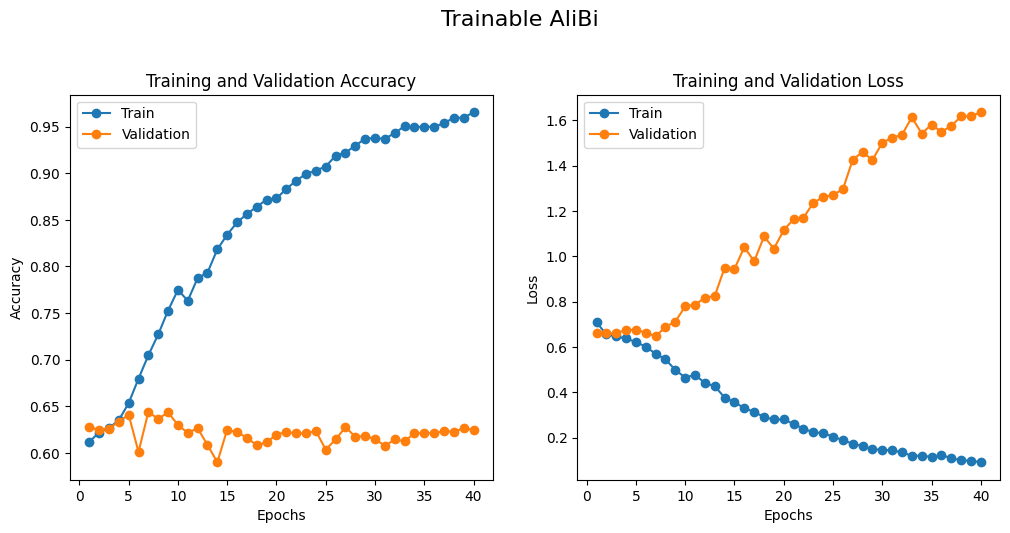

In [ ]:
def plot_metrics(history):
    train_accuracies = history['train_accuracies']
    train_losses = history['train_losses']
    val_accuracies = history['val_accuracies']
    val_losses = history['val_losses']
    epochs = range(1, len(train_accuracies) + 1)


    plt.figure(figsize=(12, 5))

    plt.suptitle('Trainable AliBi', fontsize=16, y=1.05)

    # Plot accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Train', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train', marker='o')
    plt.plot(epochs, val_losses, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_metrics(history)